In [108]:
#import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

#import preprocessing/modeling/error metric packages
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsRegressor

In [46]:
combined_avg = pd.read_csv('../raw_data/combined_avg.csv', index_col='time', parse_dates=True)

In [47]:
combined_avg.head(2)

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,price day ahead,price actual,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,...,50.1,65.41,272.491463,1016.4,82.4,2.0,135.2,0.0,0.0,0.0
2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,...,48.1,64.92,272.512700,1016.2,82.4,2.0,135.8,0.0,0.0,0.0


In [48]:
combined_avg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35064 non-null  float64
 1   generation fossil brown coal/lignite         35064 non-null  float64
 2   generation fossil gas                        35064 non-null  float64
 3   generation fossil hard coal                  35064 non-null  float64
 4   generation fossil oil                        35064 non-null  float64
 5   generation hydro pumped storage consumption  35064 non-null  float64
 6   generation hydro run-of-river and poundage   35064 non-null  float64
 7   generation hydro water reservoir             35064 non-null  float64
 8   generation nuclear                           35064 non-null  float64
 9   generation other         

In [49]:
#function to make train-test split for time-indexed data
def ts_train_test(data, target_col_name = 'total load actual', test_size=0.15, stdzd=False, cols_to_scale=None):
    df = data.copy()
    test_index = int(len(df)*(1-test_size)) #get index where test set begins
        
    X_train = df.drop([target_col_name,'total load forecast'], axis = 1).iloc[:test_index]
    y_train = df[target_col_name].iloc[:test_index]
    X_test = df.drop([target_col_name,'total load forecast'], axis = 1).iloc[test_index:]
    y_test = df[target_col_name].iloc[test_index:]
    
    # StandardScaler fit seperately on training and test sets
    if stdzd == True:
        scaler = StandardScaler()
        X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
        X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
    
    return X_train, X_test, y_train, y_test        

In [50]:
#Let's engineer some categorical features for use in a regression model like weekend/weekday, winter/summer/spring-fall
df_features = combined_avg.iloc[:,16:].drop(['price day ahead', 'price actual'], axis=1)
df_features.head()

,total load forecast,total load actual,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all
time,,,,,,,,,,
2014-12-31 23:00:00+00:00,26118.0,25385.0,272.491463,1016.4,82.4,2.0,135.2,0.0,0.0,0.0
2015-01-01 00:00:00+00:00,24934.0,24382.0,272.512700,1016.2,82.4,2.0,135.8,0.0,0.0,0.0
2015-01-01 01:00:00+00:00,23515.0,22734.0,272.099137,1016.8,82.0,2.4,119.0,0.0,0.0,0.0
2015-01-01 02:00:00+00:00,22642.0,21286.0,272.089469,1016.6,82.0,2.4,119.2,0.0,0.0,0.0
2015-01-01 03:00:00+00:00,21785.0,20264.0,272.145900,1016.6,82.0,2.4,118.4,0.0,0.0,0.0


In [51]:
#function to calculate basic season label based on month
def season_determination(month):
    if month in [6,7,8,9]: #June-Sept = summer (highest need for cooling in Spain)
        return "summer"
    elif month in [1,2,12]: #Dec, Jan, Feb = winter (highest need for heating)
        return "winter"
    else:
        return "spring/fall" #all other months are spring or fall (similar lower needs for heating/cooling)

In [52]:
day_of_week = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3: 'Thursday', 4: 'Friday', 5:'Saturday', 6:'Sunday'}
df_features['hour'] = df_features.index.hour
df_features['weekday'] = df_features.index.weekday.map(day_of_week)
df_features['month'] = df_features.index.month #have to create month column because cannot apply() on datetimeindex
df_features['season'] = df_features.month.apply(season_determination)
df_features['nonwork-work_day'] = np.where(df_features.index.weekday > 5, 0, 1)
display(df_features.shape, df_features.head());

(35064, 15)

,total load forecast,total load actual,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all,hour,weekday,month,season,nonwork-work_day
time,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,26118.0,25385.0,272.491463,1016.4,82.4,2.0,135.2,0.0,0.0,0.0,23,Wednesday,12,winter,1
2015-01-01 00:00:00+00:00,24934.0,24382.0,272.512700,1016.2,82.4,2.0,135.8,0.0,0.0,0.0,0,Thursday,1,winter,1
2015-01-01 01:00:00+00:00,23515.0,22734.0,272.099137,1016.8,82.0,2.4,119.0,0.0,0.0,0.0,1,Thursday,1,winter,1
2015-01-01 02:00:00+00:00,22642.0,21286.0,272.089469,1016.6,82.0,2.4,119.2,0.0,0.0,0.0,2,Thursday,1,winter,1
2015-01-01 03:00:00+00:00,21785.0,20264.0,272.145900,1016.6,82.0,2.4,118.4,0.0,0.0,0.0,3,Thursday,1,winter,1


In [53]:
df_features.drop("month", axis=1, inplace=True)

Now that I've used the weekday and month to create the type_of_day and season columns, 
I need to drop the month column because the test set may not contain all months. Now time to one-hot encode the new categorical variables.

In [54]:
#let's split data and then encode the new catergorical variables
X_train, X_test, y_train, y_test = ts_train_test(data = df_features, stdzd=True, 
                                                 cols_to_scale=['temp','pressure','humidity',
                                                                'wind_speed','rain_1h','snow_3h','clouds_all'])
cat_cols = ['hour','weekday','season']
X_train_cat = X_train[['hour','weekday','season']]
X_test_cat = X_test[['hour','weekday','season']]

encoder = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore')

encoder.fit(X_train_cat)
X_train.drop(columns = cat_cols, inplace=True)
X_train_cat = pd.DataFrame(encoder.transform(X_train_cat), index=X_train.index, 
                           columns = encoder.get_feature_names_out()).astype(int)
X_train = X_train.join(X_train_cat, how ='outer')
#X_train.head()
encoder.fit(X_test_cat)
X_test.drop(columns = cat_cols, inplace=True)
X_test_cat = pd.DataFrame(encoder.transform(X_test_cat), index = X_test.index, 
                           columns = encoder.get_feature_names_out()).astype(int)
X_test = X_test.join(X_test_cat, how ='outer')

display(X_train.head(3), X_test.head(3), X_train.columns)

,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all,nonwork-work_day,hour_1,...,hour_22,hour_23,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,season_summer,season_winter
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,-2.327401,0.038628,0.980456,-0.349236,135.2,-0.369491,-0.052006,-1.423223,1,0,...,0,1,0,0,0,0,0,1,0,1
2015-01-01 00:00:00+00:00,-2.324453,0.015395,0.980456,-0.349236,135.8,-0.369491,-0.052006,-1.423223,1,0,...,0,0,0,0,0,1,0,0,0,1
2015-01-01 01:00:00+00:00,-2.381861,0.085093,0.953265,-0.064045,119.0,-0.369491,-0.052006,-1.423223,1,1,...,0,0,0,0,0,1,0,0,0,1


,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all,nonwork-work_day,hour_1,...,hour_22,hour_23,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,season_summer,season_winter
time,,,,,,,,,,,,,,,,,,,,,
2018-05-26 19:00:00+00:00,0.656574,-0.333094,-0.243123,-0.064045,206.0,-0.369491,-0.052006,-0.265015,1,0,...,0,0,0,1,0,0,0,0,0,0
2018-05-26 20:00:00+00:00,0.456407,-0.309861,0.341476,-0.349236,142.0,-0.369491,-0.052006,-0.589313,1,0,...,0,0,0,1,0,0,0,0,0,0
2018-05-26 21:00:00+00:00,0.295386,-0.263396,0.626978,-0.919619,98.0,-0.369491,-0.052006,-0.728298,1,0,...,0,0,0,1,0,0,0,0,0,0


Index(['temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h',
       'snow_3h', 'clouds_all', 'nonwork-work_day', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'season_summer', 'season_winter'],
      dtype='object')

So now X is split into train and test sets, with the first 85% of the data going to training to try to predict approximately the last 7 months out of the four years of data.

# Modeling

First I have written a couple helper functions for calculating error metrics and for creating a TS plot comparing predicted vs actual load for the various forecasting models I will try out.

### Helper functions

In [93]:
#fnc for calculating and presenting error metrics
#error_dict = {} #dict to hold model name and error metrics for various models that are investigated

def error_metrics(y_true, y_pred, model_name = None):
    '''
        function will print RMSE, R2, MAE, MAPE. Assumes y_pred is np array
    '''
    RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
    R2 = r2_score(y_true, y_pred)
    MAE = mean_absolute_error(y_true, y_pred)
    MAPE = (np.mean(np.abs((y_true - y_pred) / y_true)) * 100)

    print('\nError metrics for model: {}'.format(model_name))
    print("RMSE: %.2f" % RMSE)
    print('Variance/R^2: %.2f' % R2)
    print('MAE: %.2f' % MAE)
    print('Mean Absolute Percentage Error: %.2f %%' % MAPE)

In [56]:
#fnc for plotting time series of predicted vs true values
def plot_ts_pred_true(y_pred, y_true, model_name=None):
    fig, ax = plt.subplots(figsize =(15,10))
    ax.plot(y_true.index, y_pred, linestyle='-', linewidth=1, label = 'Model Forecasted Total Load', color = 'blue',alpha = 0.4)
    y_true.plot(linestyle='-', linewidth=1, label = 'Actual Total Load', color = 'red',alpha = 0.4)

    plt.ylabel('Load/Demand (MW)')
    plt.xlabel("Time")
    plt.title("Observed vs model-predicted total load (MWH) using {}".format(model_name))
    plt.legend()
    plt.show()

Let's try out a simple linear regression using the weather and categorical variables:
### Linear Regression

In [57]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [94]:
error_metrics(linreg.predict(X_train), y_train, model_name = 'simple linear regression (train set)')


Error metrics for model: simple linear regression (train set)
RMSE: 2858.13
Variance/R^2: 0.36
MAE: 2201.35
Mean Absolute Percentage Error: 7.63 %


In [95]:
error_metrics(linreg.predict(X_test), y_test, model_name = 'simple linear regression (test set)')


Error metrics for model: simple linear regression (test set)
RMSE: 2849.47
Variance/R^2: 0.36
MAE: 2174.27
Mean Absolute Percentage Error: 7.55 %


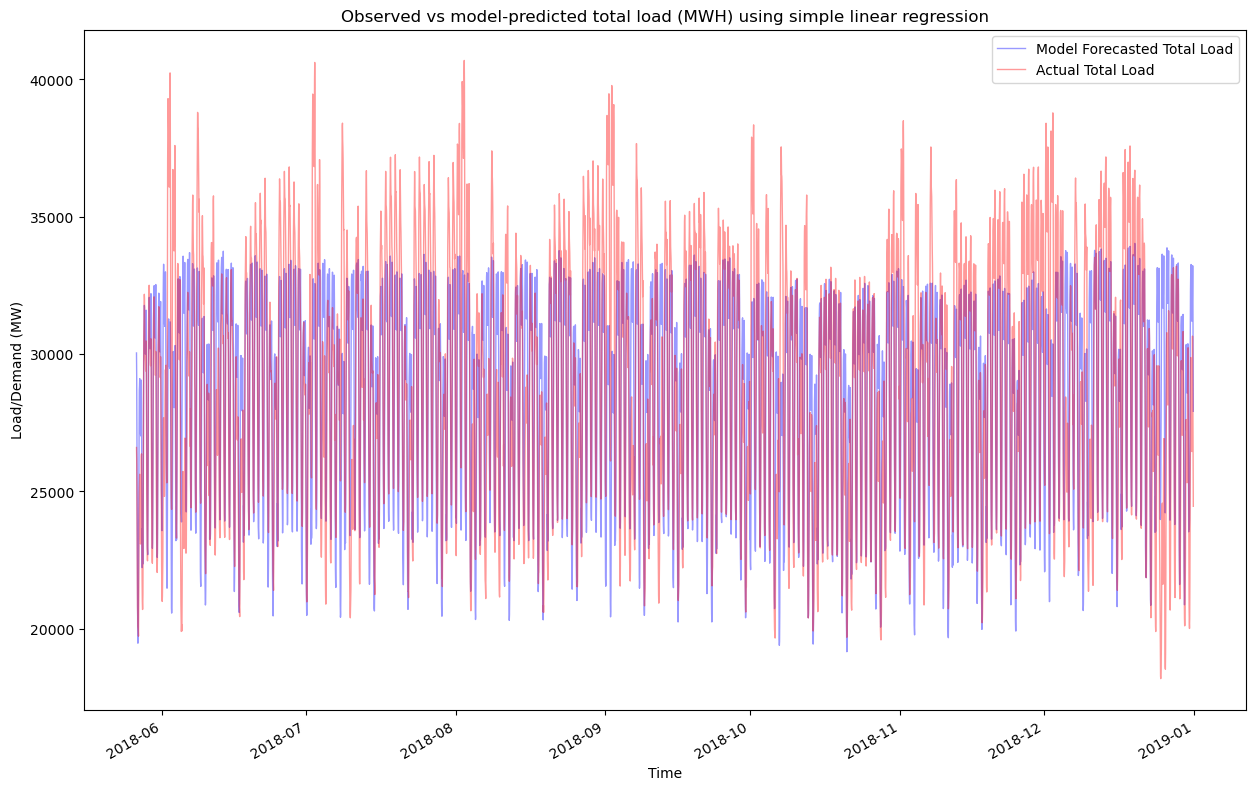

In [60]:
plot_ts_pred_true(y_pred = linreg.predict(X_test), y_true = y_test, model_name = "simple linear regression")

In [61]:
#let's try using a df with reduced feature space, by eliminating some possibly extraneous variables:

X_train_red = X_train.drop(['hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday', 
       'weekday_Thursday', 'weekday_Tuesday','weekday_Wednesday',], axis=1)
X_test_red = X_test.drop(['hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday', 
       'weekday_Thursday', 'weekday_Tuesday','weekday_Wednesday',], axis=1)

### Linear regression on reduced feature space

In [62]:
linreg_red = LinearRegression()
linreg_red.fit(X_train_red, y_train)

LinearRegression()

In [96]:
error_metrics(y_train, linreg_red.predict(X_train_red), model_name = 'simple linear regression on reduced features (train set)')


Error metrics for model: simple linear regression on reduced features (train set)
RMSE: 3949.44
Variance/R^2: 0.25
MAE: 3247.32
Mean Absolute Percentage Error: 11.67 %


We can see that the simple linear regression model using the larger set of features predicts the weekly seasonality fairly well but is often over or underpredicting the max daily load. The model using the reduced feature space performs worse. Let's also check out a baseline model that just predicts the same as the value for the same date/time from the previous year:
### Simple Year-over-Year Baseline 

In [97]:
# errors metrics for a baseline forecast (that simply repeats the values from the previous year)
#error_metrics(y_true, y_pred, model_name = None)
_ = error_metrics(y_test, df_features.loc[X_test.index.shift(-8760, freq='H'), 'total load actual'],
              model_name='Baseline forecast (repeat of previous year)')



Error metrics for model: Baseline forecast, repeat of previous year
RMSE: 3100.81
Variance/R^2: 0.54
MAE: 2249.00
Mean Absolute Percentage Error: nan %


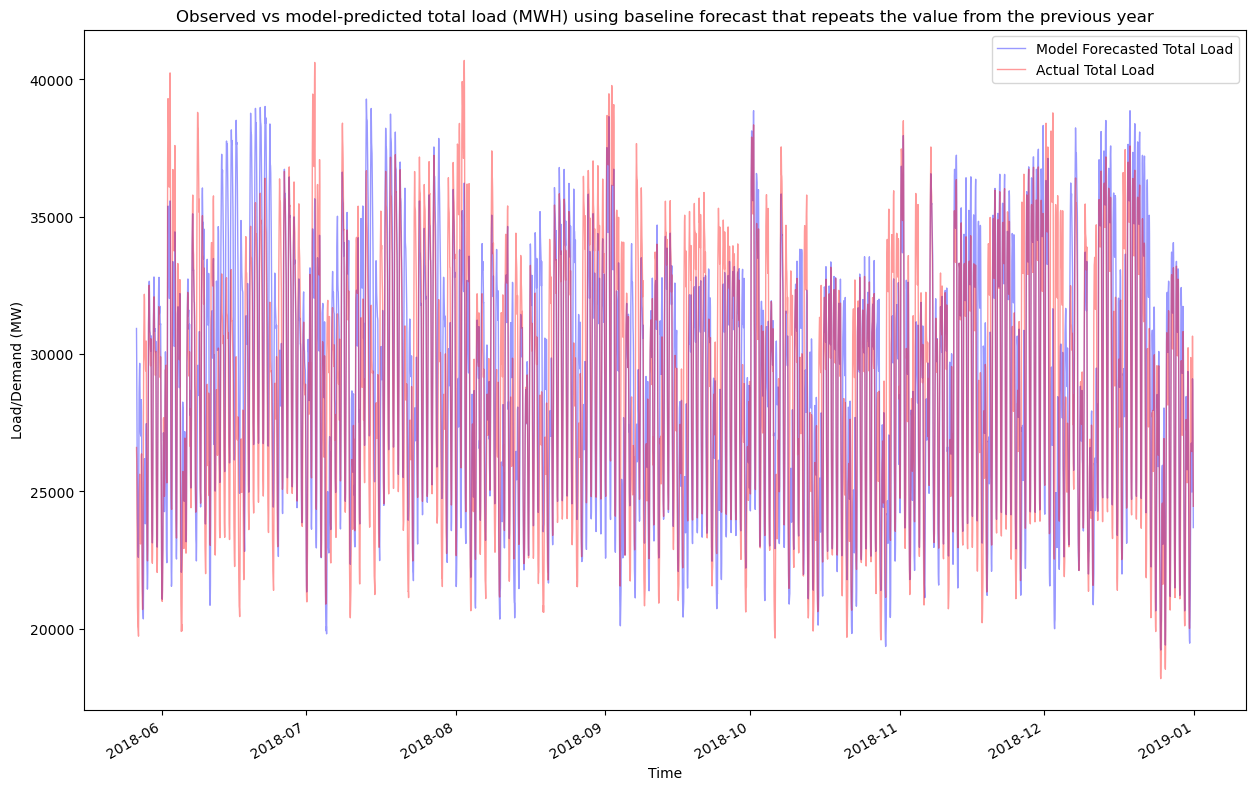

In [65]:
#def plot_ts_pred_true(y_pred, y_true, model_name=None):
plot_ts_pred_true(y_pred = df_features.loc[X_test.index.shift(-8760, freq='H'), 'total load actual'], y_true = y_test, 
                  model_name = "baseline forecast that repeats the value from the previous year")

Visually we can can see that the baseline model that just uses the value from the same time from the previous year does a decent job, but misses the max pretty badly sometimes. Which makes sense, because on average things are similar year to year but the peak demand will definitely be much higher or much lower on certain days. Let's try out a couple more regression models before trying some time series forecasting:

### Random Forest

In [72]:
#set up a parameter grid of differenet values for GridSearchCV of number of trees and max depth
n_est = [int(n) for n in np.logspace(start=1, stop=2.5, num=12)]
max_depth = list(range(1,6))

param_grid = {
        'n_estimators': n_est,
        'max_depth': max_depth
}
param_grid

{'n_estimators': [10, 13, 18, 25, 35, 48, 65, 90, 123, 168, 231, 316],
 'max_depth': [1, 2, 3, 4, 5]}

In [77]:
#create instance of base model
rfreg = RandomForestRegressor()

#create TS splits for cross val (instead of random splits, this uses progressively larger sets starting from beginning)
tss = TimeSeriesSplit(n_splits=5)

#create instance of RandomSearchCV
rf_cv = RandomizedSearchCV(rfreg, param_distributions=param_grid, cv=tss, random_state=47)

# Fit the random search model using reduced feature space X set
rf_cv.fit(X_train_red, y_train)

rf_cv.best_params_


{'n_estimators': 65, 'max_depth': 5}

The R^2 score:

In [79]:
rf_cv.score(X_train_red, y_train)

0.2829629456955861

In [80]:
rf_cv.score(X_test_red, y_test)

0.26277576129048186

In [98]:
#RF error metrics
_ = error_metrics(y_train, rf_cv.predict(X_train_red),  
                  model_name = 'Random Forest Regression on reduced feature space tuned with Random Search CV (train set)')


Error metrics for model: Random Forest Regression on reduced feature space tuned with Random Search CV (train set)
RMSE: 3870.36
Variance/R^2: 0.28
MAE: 3175.35
Mean Absolute Percentage Error: 11.45 %


Let's also try Random Forest on the full feature space dataset:

In [86]:
#create instance of base model
rfreg = RandomForestRegressor()

#create TS splits for cross val (instead of random splits, this uses progressively larger sets starting from beginning)
tss = TimeSeriesSplit(n_splits=5)

#create instance of RandomSearchCV
rf_cv_full = RandomizedSearchCV(rfreg, param_distributions=param_grid, cv=tss, random_state=47)

# Fit the random search model using reduced feature space X set
rf_cv_full.fit(X_train, y_train)

rf_cv_full.best_params_

{'n_estimators': 65, 'max_depth': 5}

In [87]:
rf_cv_full.score(X_train, y_train)

0.3722236786806894

In [88]:
rf_cv_full.score(X_test, y_test)

0.3808066843352619

In [99]:
_ = error_metrics(y_train, rf_cv_full.predict(X_train), 
                  model_name = 'Random Forest Regression tuned with Random Search CV (train set)')


Error metrics for model: Random Forest Regression tuned with Random Search CV (train set)
RMSE: 3621.45
Variance/R^2: 0.37
MAE: 2854.51
Mean Absolute Percentage Error: 10.21 %


In [100]:
_ = error_metrics(y_test, rf_cv_full.predict(X_test), 
                  model_name = 'Random Forest Regression tuned with Random Search CV (test set)')


Error metrics for model: Random Forest Regression tuned with Random Search CV (test set)
RMSE: 3612.51
Variance/R^2: 0.38
MAE: 2843.07
Mean Absolute Percentage Error: 9.90 %


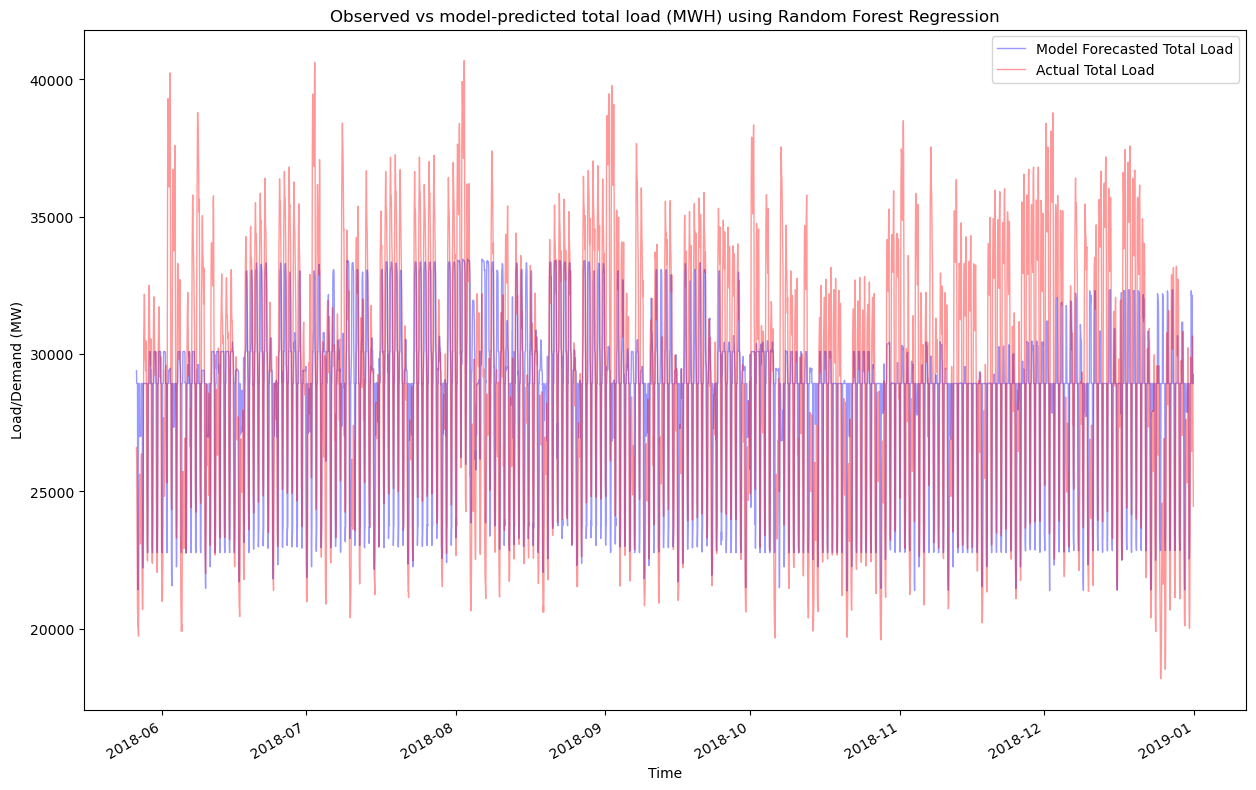

In [101]:
plot_ts_pred_true(y_pred = rf_cv_full.predict(X_test), y_true = y_test, model_name = "Random Forest Regression")

So Random Forest performs slightly worse that linear regression. It seems to consistently underpredict the true values. Let's also try KNeighbors Regression:

In [106]:
#set up a parameter grid for KNeighbors Random CV search:

n_neigh = [int(n) for n in np.logspace(start=0.5, stop=1.8, num=10)]
weights = ['uniform', 'distance']
leaf_size = [int(n) for n in np.logspace(start=0.5, stop=1.9, num=6)]

kn_param_grid = {
        'n_neighbors': n_neigh,
        'weights': weights,
        'leaf_size':leaf_size
}
kn_param_grid

{'n_neighbors': [3, 4, 6, 8, 11, 16, 23, 32, 45, 63],
 'weights': ['uniform', 'distance'],
 'leaf_size': [3, 6, 11, 21, 41, 79]}

In [109]:
#create instance of base model
kn = KNeighborsRegressor()

#create TS splits for cross val (instead of random splits, this uses progressively larger sets starting from beginning)
tss = TimeSeriesSplit(n_splits=5)

#create instance of RandomSearchCV
kn_cv = RandomizedSearchCV(kn, param_distributions = kn_param_grid, cv=tss, random_state=47)

# Fit the random search model using reduced feature space X set
kn_cv.fit(X_train, y_train)

kn_cv.best_params_


{'weights': 'distance', 'n_neighbors': 11, 'leaf_size': 41}

In [110]:
kn_cv.score(X_train, y_train)

0.9999999999410343

In [111]:
kn_cv.score(X_test, y_test)

0.29830412068273116

In [112]:
_ = error_metrics(y_test, kn_cv.predict(X_test), 
                  model_name = 'KNeighbors Regression tuned with Random Search CV (test set)')


Error metrics for model: KNeighbors Regression tuned with Random Search CV (test set)
RMSE: 3845.65
Variance/R^2: 0.30
MAE: 3071.26
Mean Absolute Percentage Error: 10.55 %


As expected, this model wildly overfits the training data and performs fairly poorly on the test data. Now to try some time series forecasting.

# Time Series Forecasting

In [128]:
#%conda install -c conda-forge sktime
#import packages
import sktime
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

In [122]:
#let's create a simple time series DF for use in models without the exogenous variables
ts_load = pd.DataFrame(combined_avg["total load actual"], columns=['total load actual'])
ts_load.head()

,total load actual
time,
2014-12-31 23:00:00+00:00,25385.0
2015-01-01 00:00:00+00:00,24382.0
2015-01-01 01:00:00+00:00,22734.0
2015-01-01 02:00:00+00:00,21286.0
2015-01-01 03:00:00+00:00,20264.0


In [131]:
#let's use the simple ts df to test for stationarity, as many ts models assume stationarity
adf_result = adfuller(ts_load)
#print test statisitc
print("t-stat", adf_result[0])
# Print p-value
print("p-value", adf_result[1])
# Print number of lags used
print("#lags used", adf_result[2])
# Print critical values
print("critical values", adf_result[4]) 

t-stat -21.420315756960576
p-value 0.0
#lags used 52
critical values {'1%': -3.43053679213716, '5%': -2.8616225575095284, '10%': -2.566813942767471}


With a p-value of zero, we can say that the data have no trend, so we don't need to worry about doing any detrending.